In [ ]:
!pip install -Uqq fastbook 
import fastbook 
fastbook.setup_book() 

     |████████████████████████████████| 727kB 14.0MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 194kB 55.0MB/s 
     |████████████████████████████████| 1.2MB 49.6MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 12.8MB 44.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


#Libraries Needed

In [ ]:
from google.colab import drive, files

import re
import PIL
import numpy as np
import torch
import pandas as pd
import os
import gc
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 

from sklearn.preprocessing import LabelEncoder, StandardScaler

from fastbook import *
from fastai.vision.all import *
from sklearn.metrics import f1_score, confusion_matrix

#Unzip 
Unzip the dataset! 

In [ ]:
%%bash 
# unzip /content/gdrive/MyDrive/SpeechRecognition/spectogram.zip
# unzip /content/gdrive/MyDrive/SpeechRecognition/mfcc.zip
unzip /content/gdrive/MyDrive/SpeechRecognition/mel_spectogram.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#Paths
Get the pathway to all the images. 

In [ ]:
path_spec = Path('/content/spec/train_images') 
path_mel =  Path('/content/mel_spec/train_images') 
path_mfcc = Path('/content/mfcc/train_images') 

paths = [path_mel, path_spec, path_mfcc]

Since, the name for all the test and train files are the same, we can create a common list for all examples, train set, validation set, and test set. 

The function below, `total_values`, is used to get all the relative paths of each file and the number of categories. 

`total_files`: The variable holds the relative path of each file i.e.  `parent_file_name/file_name.jpg` 
`cats`: The variable holds the different catergorical names. 

In [ ]:
def total_values(train_audio): 
  sum, cats = 0, os.listdir(train_audio)
  print(f'Total number of categories is {len(cats)-1}')

  audio = []

  for cat in cats:
    if cat != '_background_noise_':
      pth = os.path.join(train_audio, cat)
      files = [os.path.join(cat, f) for f in os.listdir(pth)]
      audio.append(files)
      numbs = len(files)
      print(cat, numbs)
      sum += numbs

  print(f'Total number of examples are {sum}')

  return cats, [j for cat in audio for j in cat]
cats, total_files = total_values(path_spec)

Total number of categories is 30
one 2370
three 2356
stop 2380
seven 2377
marvin 1746
four 2372
wow 1745
house 1750
five 2357
right 2367
bird 1731
tree 1733
down 2359
off 2357
cat 1733
happy 1742
eight 2352
go 2372
on 2367
nine 2364
six 2369
sheila 1734
zero 2376
bed 1713
left 2353
yes 2377
up 2375
dog 1746
no 2375
two 2373
Total number of examples are 64721


#Some Common Functions

Before we begin with the training, I am listing below the common functionalities that are repeated for each model. 

##Get Image Files

Through this function, I will be getting the paths for both Train and Validation dataset. 

I have specifically left out the Test set to have an unseen data that can be run to check the real accuracy of the model. 

In [ ]:
def get_image_files():
  return [*train,*val] 

##Get the Label
The label for each audio file is the parent folder it is kept in. However, the issue is how to obtain the name of that folder. 

By `label_func`, I make the process easier for obtaining the label of each audio file using the regular expression `r'([^/]+)/'`



In [ ]:
def label_func(fname):
  return re.findall(r'([^/]+)/', str(fname))[-1]

##Splitting the Dataset 
To test the accuracy of the model during training, I need a validation set. The model will only show the accuracy or error rate on this set. Furthermore, this reduces the chances of overfitting.  

By `split`, I will create two sets: train and validation set. The function returns `True` for all paths to the validation folder and `False` to the train set. 



In [ ]:
def split(fpath):
  return  fpath in val

##Threshold

Since, the test set in Kaggle has various audio clips that contain white noise or unknown sounds, I need to determine a confidence level in the model. 

This is done by creating the function `thresh` which  will only keep the predictions with confidence levels higher than `n`. 

`preds_max` holds the confidence level of the for each prediction. 

In [ ]:
def thresh(n, pred):
  preds_thresh = []
  vals = [p > n for p in preds_max]
  for id, v in enumerate(vals):
    if v == True: 
      preds_thresh.append(pred[id])
    else: preds_thresh.append('silence')
  return preds_thresh

##Confusion Matrix

The `ConfusionMatrix` is a graphical representation of the function `confusion_matrix` by SKLearn on `pred` and `true` i.e. the predicted label and the actual label. 


In [ ]:
def ConfusionMatrix(pred, true):  
  matrix = confusion_matrix(pred, true)

  fig, ax = plt.subplots(figsize=(15, 15))
  ax= plt.subplot()
  sns.heatmap(matrix, annot=True, cmap='Blues',ax = ax, fmt='g');

  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(dls_spec.vocab, Rotation = 45); 
  ax.yaxis.set_ticklabels(dls_spec.vocab, Rotation = 0);

##Decode Predictions

In [ ]:
def get_cats(pred): 
  cats = dls.vocab
  return [cats[i] for i in pred]

##Splitting Dataset

In [ ]:
def train_test_val():
  val = pd.read_csv('/content/validation_list.txt').values.flatten()
  val = [f'{v[:-3]}jpg' for v in val]

  test = pd.read_csv('/content/testing_list.txt').values.flatten()
  test = [f'{t[:-3]}jpg' for t in test]

  train = [t for t in total_files if t not in [*test,*val]]

  return train, val, test


#Dataset 
Create a dataloader using Spectrogram, Mel Spectrogram, and MFCC Spectrogram 

Get the train, validation, and test file path for the spectogram images. 


In [ ]:
train, val, test= train_test_val() 

Get the images for train, validation and test set!

To do this I will create the `SpectrogramImages` class. This class will take in PILImage class and do certain modifications.

In [ ]:
class SpectrogramImages(fastuple):
  def show(self, ctx=None):
    img1,img2,img3,label = self
    if (type(label)!=str): label = spec_tfm.vocab[label]
    imgs = [] 
    for im in [img1,img2, img3]: 
      img = transforms.Resize(256)(im)
      img = transforms.CenterCrop((255, 300))(img)
      imgs.append(img)
    
    t1,t2,t3 = tensor(imgs[0]), tensor(imgs[1]), tensor(imgs[2])
    return show_image(torch.cat((t1,t2,t3),1), title = label, figsize=(12,8))

In [ ]:
img1 = PILImage.create(paths[0]/train[0])
img2 = PILImage.create(paths[1]/train[0])
img3 = PILImage.create(paths[2]/train[0])
label = label_func(train[0])

In [ ]:
s = SpectrogramImages(img1, img2, img3,label) 

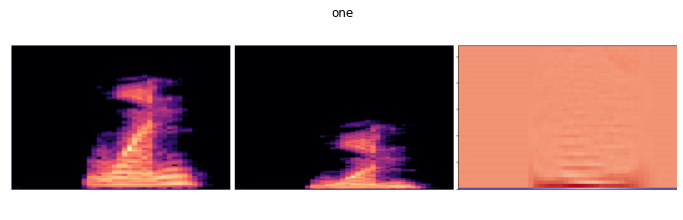

In [ ]:
s.show();

In [ ]:
class SpectogramTransf(Transform):
    def __init__(self, files, label_func, splits):
        self.labeller = label_func 
        vals = map(self.labeller, total_files)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)
        self.valid = L(files)[splits[1]]
            
    def encodes(self, f):
        img1,img2,img3 = PILImage.create(paths[0]/f),PILImage.create(paths[1]/f),PILImage.create(paths[2]/f)
        return SpectrogramImages(img1, img2, img3, self.o2i[self.labeller(f)])
    
    def decodes(self, x): 
      return SpectrogramImages(x[0],x[1],x[2],self.vocab[x[3]])

    def decode(self,x):
      return self.decodes(x)

In [ ]:
subset_files = get_image_files()
splits = FuncSplitter(split)(subset_files)

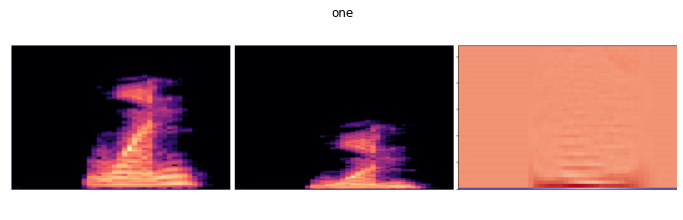

In [ ]:
spec_tfm = SpectogramTransf(subset_files, label_func, splits)
x = spec_tfm(subset_files[0])
dec = spec_tfm.decode(x)
dec.show();

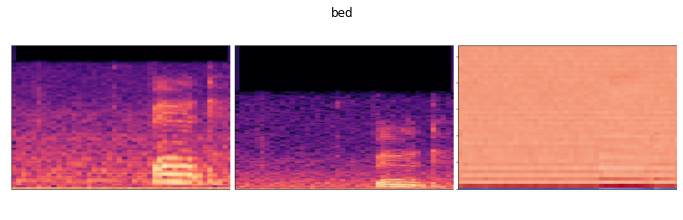

In [ ]:
tls_spec = TfmdLists(subset_files, spec_tfm, splits=splits)
show_at(tls_spec.valid, 0); 

In [ ]:
bs = 64 
dls = tls_spec.dataloaders(after_item=[Resize((224,224)), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], bs = bs)

##Test DataLoader

In [ ]:
dls_test = dls.test_dl(test, with_labels=True)

In [ ]:
x1,x2,x3,y = dls.valid.one_batch() 

#Create the Model Class

In [ ]:
class SpectrogramModelClass(Module):
  def __init__(self):
    self.encoder, self.head = create_body(resnet34, cut = -2), create_head(512*3, 30, ps = 0.5)  
  
  def forward(self, x1, x2, x3):
    ftrs = torch.cat([self.encoder(x1), self.encoder(x2),self.encoder(x3)], dim = 1)
    return self.head(ftrs)

In [ ]:
body = create_body(resnet34, cut = -2)
head = create_head(512*3, 30, ps = 0.5)  

In [ ]:
model = SpectrogramModelClass() 

#Loss Function!

In [ ]:
def binary_cross_entropy(inputs, targets):
  inputs, shape = inputs.sigmoid(), targets.shape[0]
  inputs, _ = torch.max(inputs.sigmoid(), dim = 1)  
  
  one_hot = torch.zeros(shape, 30)
  one_hot[torch.arange(shape), targets] = 1 
  
  return nn.BCEWithLogitsLoss()(inputs, one_hot.cuda())

In [ ]:
# calling activations
# activs = model(x1,x2,x3)
# checking function
binary_cross_entropy(activs,y)

TensorBase(1.7902, device='cuda:0', grad_fn=<AliasBackward>)

#Split the Model

In [ ]:
def spectrogram_splitter(model): 
  return [params(model.encoder),params(model.head)] 

#Accuracy

In [ ]:
def acc(inp, targ, thresh = 0.2, sigmoid = True):
  _, input = torch.max(inp.sigmoid(), dim = 1)  
  return (input.cuda() == targ).float().mean()

In [ ]:
acc(activs, y)

tensor(0.0781, device='cuda:0')

##Train the Classifier!

In [ ]:
learn = Learner(dls, model, loss_func=binary_cross_entropy, splitter=spectrogram_splitter, metrics=acc)

In [ ]:
learn.freeze() 

In [ ]:
learn.lr_find(stop_div=False)

In [ ]:
learn.fit_one_cycle(1, 1e-1) 

In [ ]:
learn.save('model-1'); 

In [ ]:
pred_max, pred = torch.max(preds[0], dim = 1)

In [ ]:
learn.unfreeze() 

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=1.0964781722577754e-06)

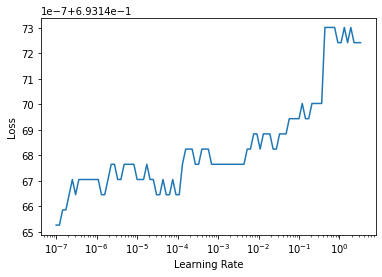

In [ ]:
learn.lr_find() 

In [ ]:
lr = 1e-01 

In [ ]:
learn.fit_one_cycle(3, slice(2e-6,lr/10)) 

epoch,train_loss,valid_loss,acc,time
0,0.693146,0.693147,0.966667,18:42
1,0.693147,0.693147,0.966667,18:30
2,0.693147,0.693147,0.966667,18:31


##Sub Test Set

In [ ]:
torch.cuda.empty_cache()

In [ ]:
gc.collect()

20901